In [1]:
import requests
from bs4 import BeautifulSoup
import urllib
import time
import pandas as pd
import csv

def get_some_page_soup(url):
    headers = {'Accept-Language': 'en',
               'X-FORWARDED-FOR': '2.21.184.0'}

    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    some_page_soup = BeautifulSoup(response.text, features="html.parser") # features="html.parser" for pycharm

    return some_page_soup

def get_actor_name(actor_url):

    headers = {'Accept-Language': 'en',
               'X-FORWARDED-FOR': '2.21.184.0'}

    response = requests.get(actor_url, headers=headers)
    actor_page_soup = BeautifulSoup(response.text, features="html.parser")

    actor_name = [(actor_page_soup.find_all('span', attrs={'class': 'itemprop'})[0].text,
                       actor_url)]

    return actor_name


def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):

    actors_soup = cast_page_soup.find_all('tr', attrs={'class': ('odd', 'even')})

    if num_of_actors_limit != None and num_of_actors_limit <= len(actors_soup):
        actors = [(actors_soup[i].find('img')['alt'],
                   urllib.parse.urljoin(cast_page_soup.find_all('link')[0]['href'], actors_soup[i].find('a')['href']))
                  for i in range(num_of_actors_limit)]
    else:
        actors = [(actors_soup[i].find('img')['alt'],
                   urllib.parse.urljoin(cast_page_soup.find_all('link')[0]['href'], actors_soup[i].find('a')['href']))
                  for i in range(len(actors_soup))]

    return actors

def actors_in_movies(movies, num_of_actors_limit):
    actors, actors_inter = [], []
    for movie in movies:
        # print(movie)
        url = movie[1] + 'fullcredits/'
        # print(url)
        headers = {'Accept-Language': 'en',
                   'X-FORWARDED-FOR': '2.21.184.0'}

        response = requests.get(url, headers=headers)

        assert response.status_code == 200
        cast_page_soup = BeautifulSoup(response.text, features="html.parser")

        # print(cast_page_soup)

        # print(get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None))

        actors_inter.append(get_actors_by_movie_soup((cast_page_soup), num_of_actors_limit))
        
    for el in actors_inter:
        for el1 in el:
            if el1 not in actors:
                actors.append(el1)

    return actors


def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movies = []

    restrictions = ('TV Series', 'Short', 'Video Game',
                    'Video short', 'Video', 'TV Movie',
                    'TV Mini Series', 'TV Series short', 'TV Special',
                    'announced', 'completed', 'voice', 'uncredited', 
                    'pre-production', 'filming', 'post-production')

    movies_soup_all = actor_page_soup.find_all('div',
                                               attrs={'class': 'filmo-category-section'})

    movies_soup = movies_soup_all[0].find_all('div',
                                              attrs={'class': ('filmo-row odd', 'filmo-row even')})

    if num_of_movies_limit == None:
        movies = [(movies_soup[i].find('a').text,
                   urllib.parse.urljoin(actor_page_soup.find_all('link')[0]['href'], movies_soup[i].find('a')['href']))
                  for i in range(len(movies_soup))
                  if all(restriction not in movies_soup[i].text for restriction in restrictions)]
    else:
        for i in range(len(movies_soup)):
            if len(movies) == num_of_movies_limit:
                break
            if all(restriction not in movies_soup[i].text for restriction in restrictions):
                movies.append((movies_soup[i].find('a').text,
                               urllib.parse.urljoin(actor_page_soup.find_all('link')[0]['href'], movies_soup[i].find('a')['href'])))

    return movies


def movies_by_actors(actors, num_of_movies_limit):
    movies, movies_inter = [], []
    for actor in actors:
        # print(actor)
        url = actor[1]
        # print(url)
        headers = {'Accept-Language': 'en',
                   'X-FORWARDED-FOR': '2.21.184.0'}

        response = requests.get(url, headers=headers)
        assert response.status_code == 200
        actor_page_soup = BeautifulSoup(response.text, features="html.parser")

        movies_inter.append(get_movies_by_actor_soup((actor_page_soup), num_of_movies_limit))

    for el in movies_inter:
        for el1 in el:
            if el1 not in movies:
                movies.append(el1)

    return movies


# All pairs distance estimation



In [2]:
popular_actors = [('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'), 
                  ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
                  ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'), 
                  ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'), 
                  ('Jackie Chan', 'https://www.imdb.com/name/nm0000329/'), 
                  ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'), 
                  ('Adam Sandler', 'https://www.imdb.com/name/nm0001191/'),  
                  ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'), 
                  ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'), 
                  ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')]


In [3]:
def get_movie_distance(actor_start_url, actor_end_url,
                       num_of_actors_limit=None, num_of_movies_limit=None):
    
    result = float('inf')
    

    if actor_start_url[8:11] == 'imd':
        actor_start_url = 'https://' + 'www.' + actor_start_url[8:]
        #print(actor_start_url)
    if actor_end_url[8:11] == 'imd':
        actor_end_url = 'https://' + 'www.' + actor_end_url[8:]
        #print(actor_end_url)

    actor_end_name = get_actor_name(actor_end_url)
    actor_start_name = get_actor_name(actor_start_url)

    global find_path # find_path to save all iterations for path determination
    find_path, seen_movies, seen_actors, movies = [], [], [], []
    
    current_distance, limit = 1, 3

    actors = actor_start_name
    find_path.append(actors)
    [seen_actors.append(actor) for actor in actors]      

    for i in range(limit):
        #print("+++++++++++++++++++++")
        print('current_distance = ', current_distance)
        
        movies = movies_by_actors(actors, num_of_movies_limit)
        print("movies = ", movies, len(movies))
        print("---------------------")
        
        movies = [movie for movie in movies if movie not in seen_movies] 
        #print("f_movies = ", movies, len(movies))
        #print("---------------------")

        find_path.append(movies)
        #print('find_path =', find_path)
        #print("---------------------")
        
        [seen_movies.append(movie) for movie in movies if movie not in seen_movies]
        #print('seen_movies =', seen_movies, len(seen_movies))
        #print("---------------------")
        
        actors = actors_in_movies(movies, num_of_actors_limit)
        print("actors = ", actors, len(actors))
        print("---------------------")
           
        actors = [actor for actor in actors if actor not in seen_actors]  
        #print("f_actors = ", actors, len(actors))
        #print("---------------------")

        find_path.append(actors)
        print('find_path =', find_path)
        print("---------------------")
        
        [seen_actors.append(actor) for actor in actors if actor not in seen_actors]
        #print('seen_actors =', seen_actors, len(seen_actors))
        #print("---------------------")

        if actor_end_name[0] in actors:
            result = current_distance 
            break
        
        current_distance += 1
       
    return result


In [4]:
st = time.time()

total = [[float('inf')]*len(popular_actors) for i in range(len(popular_actors))]
[total[i].append(popular_actors[i][0]) for i in range(len(popular_actors))]


for actor_start in popular_actors[:-1]:
    #print(popular_actors.index(actor))
    actor_start_url = actor_start[1]
    print(actor_start_url)
    print("______________") 
    actor_start_result = []
    
    actors_end = [factor_end for factor_end in popular_actors[popular_actors.index(actor_start)+1:]]
   
    path = []
    
    for i in range(len(actors_end)):
        print(actors_end[i])
        
        a = len(popular_actors) - len(actors_end)
        actor_end_url = actors_end[i][1]
        
        
        if len(path) == 7:
            print('hello3')
            for j in range(2, len(path), 2):
                print('hello3.1')
                if actors_end[i] in path[j]:
                    print('hello3.2')
                    total[popular_actors.index(actor_start)][i+a] = int(j/2)
                    print('total2=', total)       
                    
        elif 0 < len(path) < 7:
            print('hello2')
            for j in range(2, len(path), 2):
                print('hello2.1')
                if actors_end[i] in path[j]:
                    print('hello2.2')
                    total[popular_actors.index(actor_start)][i+a] = int(j/2)
                    print('total=', total)
                    
                    
                    
            if type(total[popular_actors.index(actor_start)][i+a]) != int:
                print('hello2.3')
                result = get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=5, num_of_movies_limit=5)
                
                if len(path) < len(find_path):
                    print('hello2.4')
                    path = find_path
                    print(path)
                    
                if type(result) == int:
                    print('hello2.5')
                    total[popular_actors.index(actor_start)][i+a] = result
                
                else:
                    print('hello2.6')
                    total[popular_actors.index(actor_start)][i+a] = float('inf')
                            
        else:
            print('hello1')
            result = get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=5, num_of_movies_limit=5)
            
            if len(path) < len(find_path):
                path = find_path
                print(path)
                
            if type(result) == int:
                total[popular_actors.index(actor_start)][i+a] = result
            else:
                print('hello1.1')
                total[popular_actors.index(actor_start)][i+a] = float('inf')
                
        
        #print(total[popular_actors.index(actor_start)][i+a])
        print(total[popular_actors.index(actor_start)])
    print(total[popular_actors.index(actor_start)])

print(total)
#    registr = total[popular_actors.index(actor_start)]
    #total[popular_actors.index(actor_start)].to_csv(f'{actor_start[0]}.csv', encoding='utf-8')
#    df_tr = pd.DataFrame(registr).transpose()
#    print(df_tr)
#    df_tr.to_csv(f'{actor_start[0]}.csv', encoding='utf-8')

    
#for i in range(len(total)):
#    for j in range(len(total)):
#        total[j][i] = total[i][j]  
        
#columns = [popular_actors[i][0] for i in range(len(popular_actors))]
#columns.append('Name')
        
#df = pd.DataFrame(total, columns = columns)
#df.set_index('Name', inplace=True)
#df.to_csv('df.csv', encoding='utf-8')


et = time.time()
print("Time = ", et-st, "seconds")
                                 

https://www.imdb.com/name/nm0425005/
______________
('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/')
hello1
current_distance =  1
movies =  [('Red Notice', 'https://www.imdb.com/title/tt7991608/'), ('Jungle Cruise', 'https://www.imdb.com/title/tt0870154/'), ('Jumanji: The Next Level', 'https://www.imdb.com/title/tt7975244/'), ('Fast & Furious Presents: Hobbs & Shaw', 'https://www.imdb.com/title/tt6806448/'), ('Fighting with My Family', 'https://www.imdb.com/title/tt6513120/')] 5
---------------------
actors =  [('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'), ('Ryan Reynolds', 'https://www.imdb.com/name/nm0005351/'), ('Gal Gadot', 'https://www.imdb.com/name/nm2933757/'), ('Ritu Arya', 'https://www.imdb.com/name/nm5709125/'), ('Chris Diamantopoulos', 'https://www.imdb.com/name/nm0224565/'), ('Emily Blunt', 'https://www.imdb.com/name/nm1289434/'), ('Edgar Ramírez', 'https://www.imdb.com/name/nm1183149/'), ('Jack Whitehall', 'https://www.imdb.com/name/nm3099754/'), (

# Result

In [5]:
total

[[inf, 2, 3, inf, inf, 3, 3, 3, inf, 3, 'Dwayne Johnson'],
 [inf, inf, 3, 3, 2, 3, inf, 2, inf, 3, 'Chris Hemsworth'],
 [inf, inf, inf, inf, 3, 3, inf, 1, inf, 1, 'Robert Downey Jr.'],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 'Akshay Kumar'],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 'Jackie Chan'],
 [inf, inf, inf, inf, inf, inf, 3, 3, inf, 3, 'Bradley Cooper'],
 [inf, inf, inf, inf, inf, inf, inf, 3, inf, 3, 'Adam Sandler'],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, 1, 'Scarlett Johansson'],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, 2, 'Sofia Vergara'],
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 'Chris Evans']]

# Save results in output.csv file

In [6]:
import csv
output = [[[total[j][-1], popular_actors[i][0], total[j][i]] 
            for i in range(j+1, len(popular_actors)) if total[j][-1] != popular_actors[i][0]] 
            for j in range(len(total))]

output = [item for elem in output for item in elem]

with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(output)
      
    

# Open data from output.scv file

In [7]:
file = open("output.csv", "r")
data = list(csv.reader(file, delimiter=","))
file.close()
data

for i in range(len(data)):
    if data[i][2] == 'inf':
        data[i][2] = float('inf')
    else:
        data[i][2] = int(data[i][2])

# Graphs

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
def edges(a, level = None):
    if level != None:
        a = [[a[i][0], a[i][1], a[i][2]] for i in range(len(a)) if a[i][2] == level]
    else:
        a = [[a[i][0], a[i][1], a[i][2]] for i in range(len(a)) if type(a[i][2]) == int]
    return a

def edges_labels(a, level = None):
    dictionary = {}
    for i in range(len(a)):
        if level != None:
            if a[i][2] == level:
                dictionary[(a[i][0], a[i][1])] = a[i][2]
        else:
            if type(a[i][2])==int:
                dictionary[(a[i][0], a[i][1])] = a[i][2]
    return dictionary



In [10]:
def plotting(a, level = None):

    g = nx.Graph()

    ed = edges(a, level)

    ed_labels = edges_labels(a, level = level)

    for e in ed:
        if int(e[2]) == 1:
            g.add_edge(e[0], e[1], color = 'r')
        elif int(e[2]) == 2:    
            g.add_edge(e[0], e[1], color = 'g')
        elif int(e[2]) == 3:    
            g.add_edge(e[0], e[1], color = 'b')
        

    plt.figure(figsize=(9, 9))

    pos = nx.circular_layout(g) 

    colors = nx.get_edge_attributes(g,'color').values()

    nx.draw(g, pos, labels={node: node for node in g.nodes()},
                 node_size=1200, font_size=12, node_color='lightblue', edge_color=colors)

    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=ed_labels,
        font_size=12,
        font_color='red'
    )

    return plt.show()



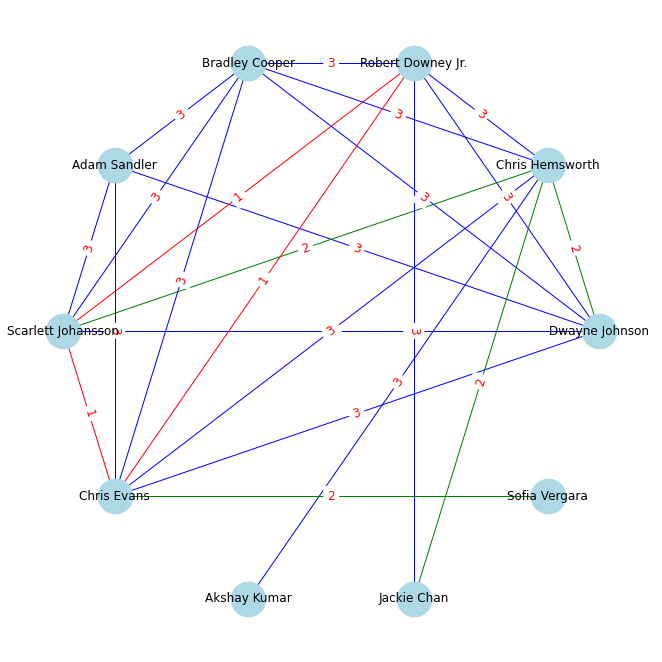

In [11]:
plotting(data, level = None)

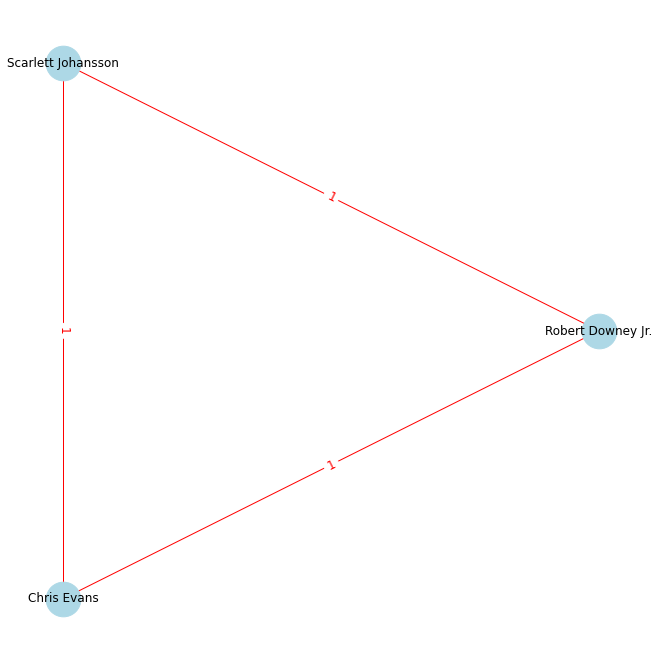

In [12]:
plotting(data, level = 1)

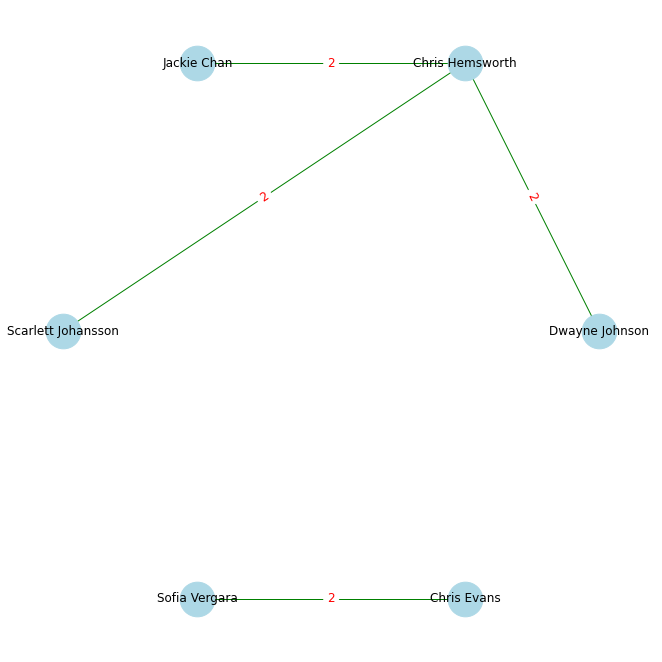

In [13]:
plotting(data, level = 2)

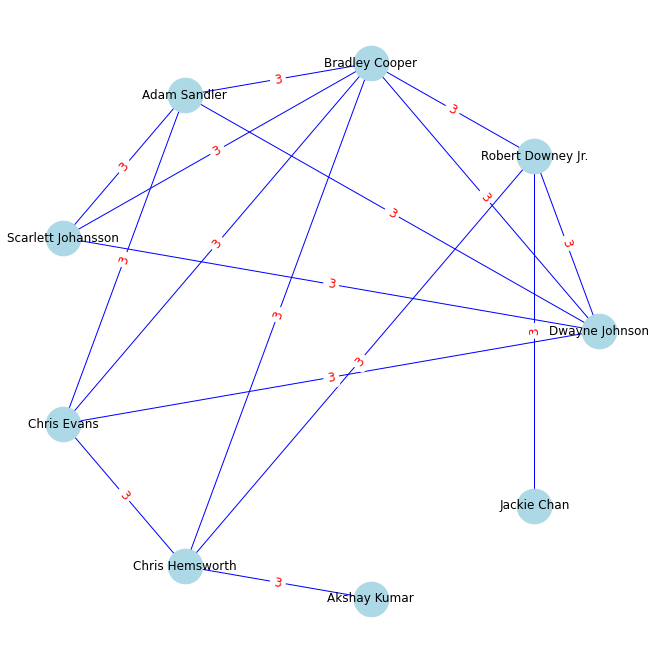

In [14]:
plotting(data, level = 3)